# Анализ АВ теста по метрике линеаризованных лайков (`𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠`)

Описание метрики:  
- считаем общий CTR в контрольной группе  𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙=𝑠𝑢𝑚(𝑙𝑖𝑘𝑒𝑠)/𝑠𝑢𝑚(𝑣𝑖𝑒𝑤𝑠)  
- посчитаем в обеих группах поюзерную метрику  𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠=𝑙𝑖𝑘𝑒𝑠−𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙∗𝑣𝑖𝑒𝑤𝑠
- сравним  t-тестом отличия в группах по метрике 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠

**Задача:**  
1. Проанализировать тест между группами 0 и 3 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?  
2. Проанализировать тест между группами 1 и 2 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?  

## Загрузка данных

Загружаем необходимые библиотеки:

In [1]:
import pandas as pd
import pandahouse as ph
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

%matplotlib inline

### Анализ АВ теста между группами 0 и 3 по метрике `𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠`

Подключаемся к базе данных: 

In [2]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20221220',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

Отбираем данные с '2022-12-02' по '2022-12-08' для 0 и 3 экспериментальной группы:

In [3]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2022-12-02' and '2022-12-08'
    and exp_group in (0,3)
GROUP BY exp_group, user_id
"""

df1 = ph.read_clickhouse(q, connection=connection)

df1.head()

,exp_group,user_id,likes,views,ctr
0,3,115383,9,30,0.300000
1,3,123580,13,48,0.270833
2,0,4944,8,41,0.195122
3,0,4504,5,15,0.333333
4,0,121508,18,88,0.204545


Посмотрим, как выглядят данные на графике гистограмме:

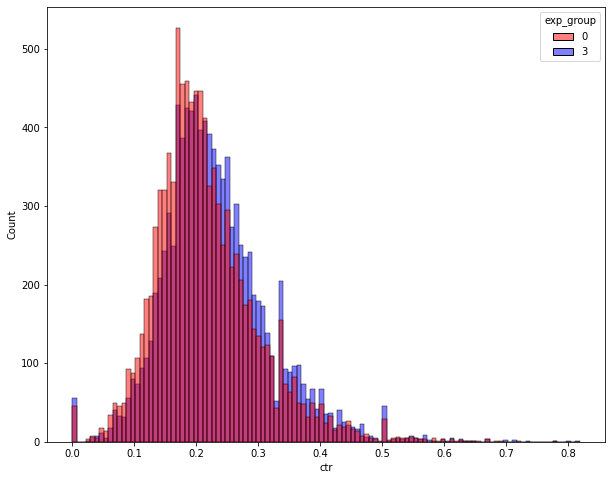

In [4]:
plt.figure(figsize=(10, 8))
groups = sns.histplot(data = df1, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

На графике мы видим, что данные двух групп распределились равномерно и примерно на "на глаз" одинаковые.

Теперь оценим результаты АВ теста для групп 0 и 3 обычным t-тестом:

In [5]:
stats.ttest_ind(df1[df1.exp_group == 0].ctr,
                df1[df1.exp_group == 3].ctr,
                equal_var=False)

Ttest_indResult(statistic=-13.896870721904069, pvalue=1.055849414662529e-43)

Результат теста показал, что существенных различий между группами нет.

Сравним t-тестом отличия в группах по метрике 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠
 и посчитаем общий CTR в контрольной группе:

In [6]:
CTRcontrol = df1[df1.exp_group == 0].likes.sum() / df1[df1.exp_group == 0].views.sum()
CTRcontrol

0.20823612262916305

In [7]:
df1['lin_likes'] = df1.likes - CTRcontrol * df1.views

Визуализируем результаты:

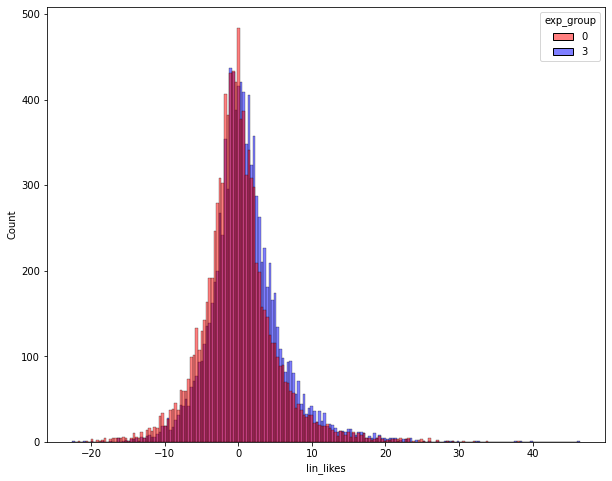

In [8]:
plt.figure(figsize=(10, 8))
groups = sns.histplot(data = df1, 
              x='lin_likes', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

In [9]:
stats.ttest_ind(df1[df1.exp_group == 0].lin_likes,
                df1[df1.exp_group == 3].lin_likes,
                equal_var=False)

Ttest_indResult(statistic=-15.21499546090383, pvalue=5.4914249479687664e-52)

Отличия видны, p-value стало значительно меньше. При это распределение, кажется, стало более нормальным в обеих группах.

### Анализ АВ теста между группами 1 и 2 по метрике 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠

Отбирём данные с '2022-12-02' по '2022-12-08' для 1 и 2 экспериментальной группы:

In [10]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2022-12-02' and '2022-12-08'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

df2 = ph.read_clickhouse(q, connection=connection)

df2.head()

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,33,122,0.270492
4,1,18392,7,32,0.218750


Визуализируем данные:

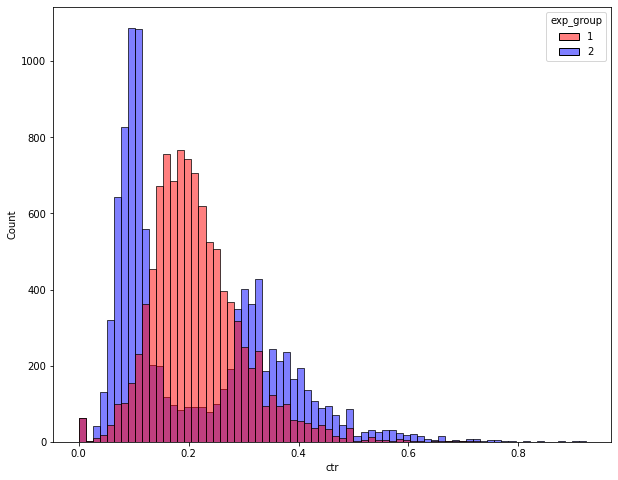

In [11]:
plt.figure(figsize=(10, 8))
groups = sns.histplot(data = df2, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

Сравним группы  t-тестом:

In [12]:
stats.ttest_ind(df2[df2.exp_group == 1].ctr,
                df2[df2.exp_group == 2].ctr,
                equal_var=False)

Ttest_indResult(statistic=0.7094392041270486, pvalue=0.4780623130874935)

Сравним t-тестом отличия в группах по метрике 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠 и посчитаем общий CTR в контрольной группе:

In [13]:
CTRcontrol2 = df2[df2.exp_group == 1].likes.sum() / df2[df2.exp_group == 1].views.sum()
CTRcontrol2

0.20802680490126244

In [14]:
df2['lin_likes'] = df2.likes - CTRcontrol2 * df2.views

Визуализируем данные:

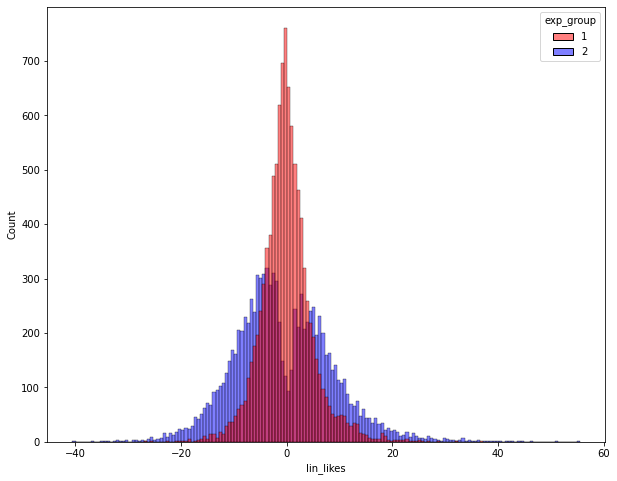

In [15]:
plt.figure(figsize=(10, 8))
groups = sns.histplot(data = df2, 
              x='lin_likes', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

Сравним группы t-тестом:

In [16]:
stats.ttest_ind(df2[df2.exp_group == 1].lin_likes,
                df2[df2.exp_group == 2].lin_likes,
                equal_var=False)

Ttest_indResult(statistic=6.122579994775973, pvalue=9.439432187037712e-10)

P-value стало значительно ниже и теперь говорит о высокой вероятности стат. значимых отличий между двумя группами, графически отличия также видны более отчётливо.

## Общий вывод

1) Для экспериментальных групп 0 и 3 t-тест показал статистически значимые различия с очень малыми p-value как на линеаризованных лайках, так и на CTR'ах. Но критерий стат. значимости после t-теста на линеаризованных лайках стал на 9 порядков меньше, чем после теста на CTR'ах, что свидетельствует о бОльшей чувствительности метрики линеаризованных лайков по сравнению с чистыми CTR'ами.  
2) Для экспериментальных групп 1 и 2 t-тест НЕ показал статистически значимых различий на метрике CTR, но тест на линеаризованных лайках дал p-value << 0.05, следовательно показал статистически значимые различия между группами. Такие различия в результатах между тестами еще больше убеждают меня в том, что метрика линеаризованных лайков гораздо чувствительнее чистых CTR'ов.